# Electricity prices (binary classification)

This benchmark uses a dataset introduced in [this paper](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.12.9405). The features contain electricity supply and demand indicators whilst the target is binary and indicates if the price of electricity goes up (`True`) or down (`False`). The target is balanced. 

In [1]:
import warnings

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

We first define a function that evaluates a given model and returns running scores along with the total time spent training the model.

In [2]:
import time

from creme import datasets
from creme import metrics


def evaluate_model(model):
    
    metric = metrics.Accuracy()
    scores = []
    duration = 0

    for i, (x, y) in enumerate(datasets.fetch_electricity()):

        y_pred = model.predict_one(x)
        metric.update(y, y_pred)
        
        tic = time.time()
        model.fit_one(x, y)
        duration += time.time() - tic

        if i > 0 and i % 500 == 0:
            scores.append(metric.get())
            
    return scores, duration

sklearn SGDClassifier
Final score: 0.9138241372413936
Training time: 9.917028903961182
----------
sklearn PassiveAggressiveClassifier
Final score: 0.909557565387441
Training time: 9.315312623977661
----------
No-change classifier
Final score: 0.8535365880758183
Training time: 0.015996694564819336
----------
Passive-aggressive II
Final score: 0.9221572853936649
Training time: 1.5407326221466064
----------
Logistic regression w/ VanillaSGD
Final score: 0.9151352192173552
Training time: 1.0152628421783447
----------
Logistic regression w/ Adam
Final score: 0.8433812581942631
Training time: 1.4007313251495361
----------
Logistic regression w/ AdaGrad
Final score: 0.8256705406546472
Training time: 1.136486291885376
----------
Logistic regression w/ RMSProp
Final score: 0.9151796626741673
Training time: 1.168750524520874
----------


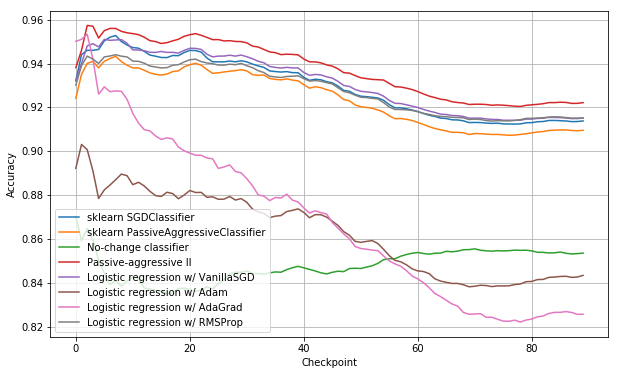

In [4]:
from creme import compat
from creme import compose
from creme import dummy
from creme import linear_model
from creme import optim
from creme import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier


models = {
    'sklearn SGDClassifier': compose.Pipeline([
        preprocessing.StandardScaler(),
        compat.CremeClassifierWrapper(
            sklearn_estimator=SGDClassifier(
                loss='log',
                learning_rate='optimal',
                fit_intercept=False
            ),
            classes=[False, True]
        )
    ]),
    'sklearn PassiveAggressiveClassifier': compose.Pipeline([
        preprocessing.StandardScaler(),
        compat.CremeClassifierWrapper(
            sklearn_estimator=SGDClassifier(
                loss='squared_hinge',
                fit_intercept=False
            ),
            classes=[False, True]
        )
    ]),
    'No-change classifier': dummy.NoChangeClassifier(),
    'Passive-aggressive II': compose.Pipeline([
        preprocessing.StandardScaler(),
        linear_model.PAClassifier(C=1, mode=2)
    ]),
    'Logistic regression w/ VanillaSGD': compose.Pipeline([
        preprocessing.StandardScaler(),
        linear_model.LogisticRegression(
            optimizer=optim.VanillaSGD(
                lr=optim.OptimalLR()
            )
        )
    ]),
    'Logistic regression w/ Adam': compose.Pipeline([
        preprocessing.StandardScaler(),
        linear_model.LogisticRegression(optim.Adam(optim.OptimalLR()))
    ]),
    'Logistic regression w/ AdaGrad': compose.Pipeline([
        preprocessing.StandardScaler(),
        linear_model.LogisticRegression(optim.AdaGrad(optim.OptimalLR()))
    ]),
    'Logistic regression w/ RMSProp': compose.Pipeline([
        preprocessing.StandardScaler(),
        linear_model.LogisticRegression(optim.RMSProp(optim.OptimalLR()))
    ])
}

fig, ax = plt.subplots(figsize=(10, 6))

for name, model in models.items():
    scores, duration = evaluate_model(model)
    ax.plot(scores, label=name)
    print(name)
    print('Final score:', scores[-1])
    print('Training time:', duration)
    print('-' * 10)
    
ax.legend()
ax.set_xlabel('Checkpoint')
ax.set_ylabel('Accuracy')
ax.grid()